# Application: Heterogeneous Effect of Gender on Wage Using Double Lasso

 We use US census data from the year 2012 to analyse the effect of gender and interaction effects of other variables with gender on wage jointly. The dependent variable is the logarithm of the wage, the target variable is *female* (in combination with other variables). All other variables denote some other socio-economic characteristics, e.g. marital status, education, and experience.  For a detailed description of the variables we refer to the help page.



This analysis allows a closer look how discrimination according to gender is related to other socio-economic variables.



First, we have to load the following packages:

In [1]:
install.packages(c("xtable","hdm"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’, ‘glmnet’, ‘checkmate’, ‘Formula’




We consider the high-dimensional linear regression model:

  $$
  Y =  \alpha_1 D + \alpha_2 DZ +  \beta W + \varepsilon.
  $$

We can load the data as follows:

In [2]:
library(hdm)
data(cps2012)
str(cps2012)

'data.frame':	29217 obs. of  23 variables:
 $ year        : num  2012 2012 2012 2012 2012 ...
 $ lnw         : num  1.91 1.37 2.54 1.8 3.35 ...
 $ female      : num  1 1 0 1 0 0 0 0 0 1 ...
 $ widowed     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ divorced    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ separated   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ nevermarried: num  0 0 0 0 0 0 1 0 0 0 ...
 $ hsd08       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ hsd911      : num  0 1 0 0 0 0 0 0 0 0 ...
 $ hsg         : num  0 0 1 1 0 1 1 0 0 0 ...
 $ cg          : num  0 0 0 0 1 0 0 0 1 0 ...
 $ ad          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ mw          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ so          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ we          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ exp1        : num  22 30 19 14 15 23 33 23.5 15 15.5 ...
 $ exp2        : num  4.84 9 3.61 1.96 2.25 ...
 $ exp3        : num  10.65 27 6.86 2.74 3.38 ...
 $ exp4        : num  23.43 81 13.03 3.84 5.06 ...
 $ weight      : num  569 626 264 257 257 ...
 $ 

You can use the following model matrix to estimate the target parameters $\alpha_1$ and $\alpha_2$:

In [3]:
# create the model matrix for the covariates
X <- model.matrix(~-1 + female + female:(widowed + divorced + separated + nevermarried +
hsd08 + hsd911 + hsg + cg + ad + mw + so + we + exp1 + exp2 + exp3) +(widowed +
divorced + separated + nevermarried + hsd08 + hsd911 + hsg + cg + ad + mw + so +
we + exp1 + exp2 + exp3)^2, data = cps2012)

X <- X[, which(apply(X, 2, var) != 0)] # exclude all constant variables

**Exercise 1:** Have a look at the proposed model matrix above and compare it with the definiton of the linear regression model. Which variables are included in $Z$ and $W$?

Z = widowed + divorced + separated + nevermarried +
hsd08 + hsd911 + hsg + cg + ad + mw + so + we + exp1 + exp2 + exp3

W = (widowed +
divorced + separated + nevermarried + hsd08 + hsd911 + hsg + cg + ad + mw + so +
we + exp1 + exp2 + exp3)^2

**Exercise 2:** Demean the model matrix $X$, i.e., calculate the mean of each variable and substract it from each observation. Why could this be important? Hint: It could be helpful to use the function *apply()*.

In [4]:
demean<- function (x){ x- mean(x)}
X<- apply(X, 2, FUN=demean)
dim(X)

[1] 29217   116

This can be helpful to calculate the CATE (cf. L2: slide 28) and ensures $\alpha_1=ATE$.

**Exercise 3:** Specify the relevant indices of the columns of $X$ that we are interested in and safe them as the variable "index.gender".
Hint: These are the indices of the covariates corresponding to $\alpha_1$ and $\alpha_2$. The function *grep()* can be helpful.

The parameter estimates for the target parameters, i.e. all coefficients related to gender (i.e. by interaction with other variables) are calculated and summarized by the following commands:



In [5]:
# target variables, index.gender specifices coefficients we are interested in
index.gender <- grep("female", colnames(X))
y <- cps2012$lnw
print(index.gender)
length(index.gender)

 [1]  1 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31


[1] 16

**Exercise 4:** Use the function *rlassoEffects* from the *hdm* package to estimate the parameters of interest. Have a look at the estimated coefficients. Do we have any significant heterogeneity? Hint: You just need to specify the *index* input parameter according to Exercise 3.

In [6]:
# this cell takes a minute to run

effects.female <- rlassoEffects(x = X, y = y, index = index.gender)


In [7]:
result <- summary(effects.female)
result$coef
library(xtable)
print(xtable(result$coef[,c(1,2,4)], type="latex"), digits=3)


,Estimate.,Std. Error,t value,Pr(>|t|)
female,-0.154923281,0.050162447,-3.08843149,2.012161e-03
female:widowed,0.136095484,0.090662629,1.50111997,1.333245e-01
female:divorced,0.136939386,0.022181700,6.17352970,6.678200e-10
female:separated,0.023302763,0.053211795,0.43792476,6.614408e-01
female:nevermarried,0.186853483,0.019942393,9.36966209,7.276511e-21
female:hsd08,0.027810312,0.120914496,0.22999982,8.180919e-01
female:hsd911,-0.119335040,0.051879684,-2.30022682,2.143537e-02
female:hsg,-0.012889780,0.019223188,-0.67053290,5.025181e-01
female:cg,0.010138553,0.018326505,0.55321800,5.801141e-01
female:ad,-0.030463745,0.021806103,-1.39702838,1.624050e-01


% latex table generated in R 4.5.0 by xtable 1.8-4 package
% Thu Jun  5 06:55:32 2025
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \hline
 & Estimate. & Std. Error & Pr($>$$|$t$|$) \\ 
  \hline
female & -0.15 & 0.05 & 0.00 \\ 
  female:widowed & 0.14 & 0.09 & 0.13 \\ 
  female:divorced & 0.14 & 0.02 & 0.00 \\ 
  female:separated & 0.02 & 0.05 & 0.66 \\ 
  female:nevermarried & 0.19 & 0.02 & 0.00 \\ 
  female:hsd08 & 0.03 & 0.12 & 0.82 \\ 
  female:hsd911 & -0.12 & 0.05 & 0.02 \\ 
  female:hsg & -0.01 & 0.02 & 0.50 \\ 
  female:cg & 0.01 & 0.02 & 0.58 \\ 
  female:ad & -0.03 & 0.02 & 0.16 \\ 
  female:mw & -0.00 & 0.02 & 0.96 \\ 
  female:so & -0.01 & 0.02 & 0.67 \\ 
  female:we & -0.00 & 0.02 & 0.84 \\ 
  female:exp1 & 0.00 & 0.01 & 0.53 \\ 
  female:exp2 & -0.16 & 0.05 & 0.00 \\ 
  female:exp3 & 0.04 & 0.01 & 0.00 \\ 
   \hline
\end{tabular}
\end{table}


**Exercise 5:** Due to multiple testing issues, have a look at the joint confidence intervals. Do we still have significant heterogeneity? Hint: Set "joint = TRUE" in the *confint()* function.

We estimate and plot confident intervals, first "pointwise" and then the joint confidence intervals.

,5 %,95 %
female,-0.237433164,-0.072413398
female:widowed,-0.013031271,0.285222239
female:divorced,0.100453736,0.173425037
female:separated,-0.064222851,0.110828376
female:nevermarried,0.154051166,0.219655800
female:hsd08,-0.171076335,0.226696960
female:hsd911,-0.204669525,-0.034000554
female:hsg,-0.044509111,0.018729551
female:cg,-0.020005866,0.040282971
female:ad,-0.066331593,0.005404103


Warning message in ggplot2::geom_hline(colour = col, ggplot2::aes(width = 0.1, h = 0, :
“Ignoring unknown aesthetics: width and h”


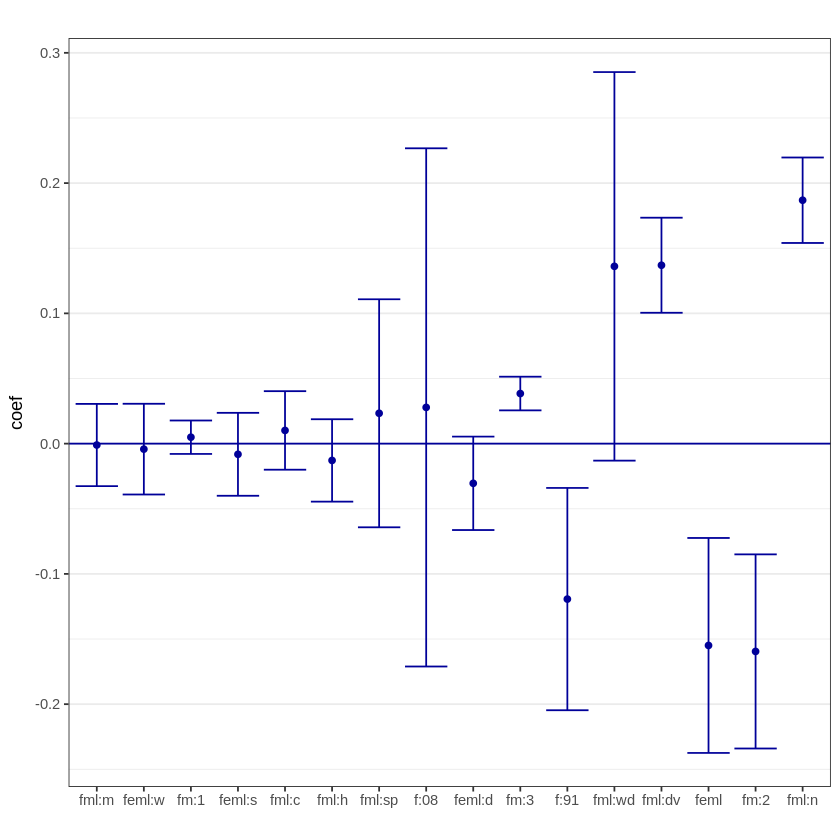

In [8]:
pointwise.CI <- confint(effects.female, level = 0.90)
pointwise.CI
plot(effects.female, level=0.90) # plot of the effects



Finally, we compare the pointwise confidence intervals to joint confidence intervals.

,5 %,95 %
female,-0.28492399,-0.02492257
female:widowed,-0.11566003,0.38785100
female:divorced,0.07894593,0.19493285
female:separated,-0.10736816,0.15397368
female:nevermarried,0.13310323,0.24060374
female:hsd08,-0.34764164,0.40326226
female:hsd911,-0.25903074,0.02036066
female:hsg,-0.06165100,0.03587144
female:cg,-0.03822194,0.05849904
female:ad,-0.09147225,0.03054476


Warning message in ggplot2::geom_hline(colour = col, ggplot2::aes(width = 0.1, h = 0, :
“Ignoring unknown aesthetics: width and h”


% latex table generated in R 4.5.0 by xtable 1.8-4 package
% Thu Jun  5 06:55:46 2025
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & 5 \% & 95 \% \\ 
  \hline
female & -0.28 & -0.02 \\ 
  female:widowed & -0.12 & 0.39 \\ 
  female:divorced & 0.08 & 0.19 \\ 
  female:separated & -0.11 & 0.15 \\ 
  female:nevermarried & 0.13 & 0.24 \\ 
  female:hsd08 & -0.35 & 0.40 \\ 
  female:hsd911 & -0.26 & 0.02 \\ 
  female:hsg & -0.06 & 0.04 \\ 
  female:cg & -0.04 & 0.06 \\ 
  female:ad & -0.09 & 0.03 \\ 
  female:mw & -0.05 & 0.05 \\ 
  female:so & -0.06 & 0.04 \\ 
  female:we & -0.06 & 0.05 \\ 
  female:exp1 & -0.02 & 0.02 \\ 
  female:exp2 & -0.28 & -0.04 \\ 
  female:exp3 & 0.02 & 0.06 \\ 
   \hline
\end{tabular}
\end{table}


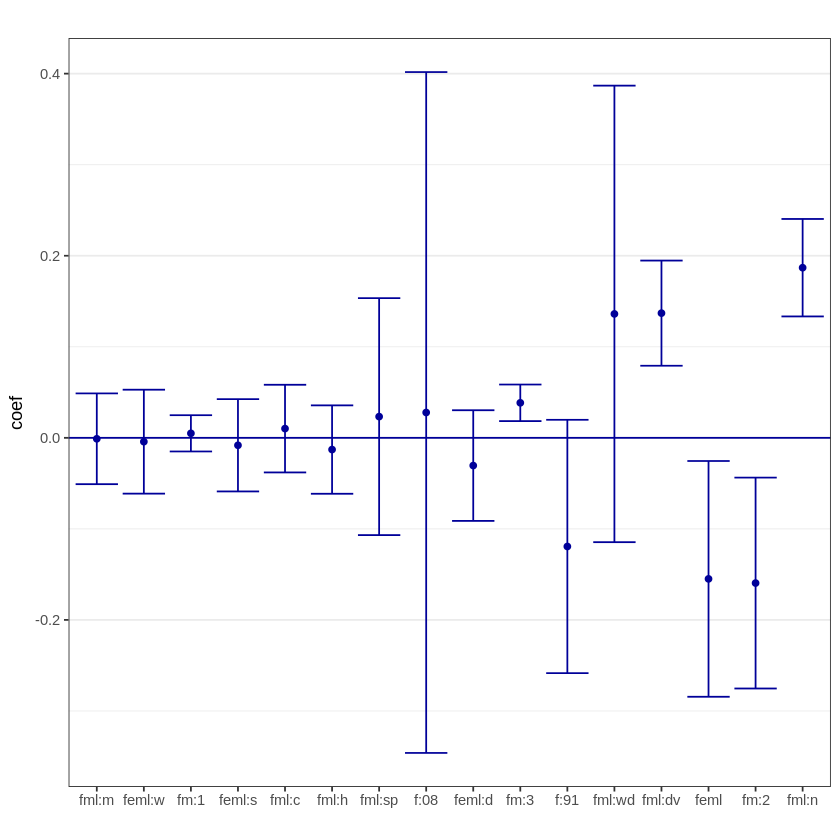

In [9]:
joint.CI <- confint(effects.female, level = 0.90, joint = TRUE)
joint.CI
plot(effects.female, joint=TRUE, level=0.90) # plot of the effects
print(xtable(joint.CI), type="latex")

# the plot output does not look great